# UQ for an Optical Potential!


In [ ]:
# (if you don't have it already)

In [ ]:
# pip install nuclear-rose 

In [4]:
# pip install corner


In [3]:
# pip install surmise

In [6]:

import rose

# other nice things
import numpy as np
import time
import os
from scipy.stats import qmc

# import stuff for nice plotting
import matplotlib.pyplot as plt
import scipy.stats as sps
from tqdm import tqdm
import random
import datetime
# !pip install corner
import corner

from scipy.stats import norm
from matplotlib.ticker import MaxNLocator

import surmise





In [7]:
print(surmise.__version__)

0.2.1


In [8]:
print(rose.__version__)

1.0.0


### Setting up the Scattering System

In [9]:
A = 40  # mass of the target
# asymptotic energy and wavenumber in center-of-mass (COM) frame
energy = 14  # MeV
# how many partial waves should we calculate?
l_max = 10
l_list = list(range(l_max + 1))
# domain of the differential cross section; the observable we want to emulate. We are setting them as equally spaced angles between 1 and 179 but this can be changed
angles = np.linspace(1, 179, 179)


### Next we either provide the experimental data we want to use, or a subset of angles and ROSE will generate mock data on them later

In [10]:
flag_provided_data =0  #Leave this as zero if user is only providing the "x" locations (the angles)



##################################################
#If providing data directly:
# angles_theta=
# anglesX=angles_theta- np.full(len(angles_theta), 1) #Moving the angles location by one because of how python works
# y_measured =   #Valueus of the observed cross section
# yerr=  #Errors of the observed cross section
# flag_provided_data=1    #Mark this as "1" if data is provided by user
##################################################


##################################################
#A subset of the angles in which we will deal with data
angles_theta=np.arange(20,160,5)
anglesX=angles_theta- np.full(len(angles_theta), 1) #Moving the angles location by one because of how python works

##################################################

### Finally some details and constants

In [17]:


AMU = 931.494102  # MeV/c^2, Particle Data Group
MASS_N = 1.008665 * AMU  # MeV/c^2 PDG
MASS_P = 1.007276 * AMU  # MeV/c^2 PDG
MASS_CHARGED_PION = 139.57039  # MeV/c^2
B_40CA = 342.0522  # BMEX

MASS_40CA = 20 * MASS_P + 20 * MASS_N - B_40CA
MU = (
    MASS_40CA * MASS_N / (MASS_40CA + MASS_N)
)  # reduced mass - we will do calculations in COM frame


k = np.sqrt(2 * MU * energy) / rose.constants.HBARC

rho=np.linspace(1e-6, 8*np.pi,2000)
s_0=6 * np.pi

In [12]:
# shape of interaction for volume term
def wood_saxon(r, R, a):
    return 1 / (1 + np.exp((r - R) / a))


# shape of interaction for surface-peaked and spin-orbit coupling terms
def wood_saxon_prime(r, R, a):
    return -1 / a * np.exp((r - R) / a) / (1 + np.exp((r - R) / a)) ** 2


# total potential with a real and central term (with the same geometry)
# and imaginary surface-peaked term, but no SO coupling
def optical_potential(r, theta):
    Vv, Wv, Wd, Vso, Rv, Rd, Rso, av, ad, aso = theta
    return (-1j * Wv - Vv) * wood_saxon(r, Rv, av) + (4j * ad * Wd) * wood_saxon_prime(
        r, Rd, ad
    )


# spin orbit interaction constant
mso = rose.constants.HBARC / MASS_CHARGED_PION


# spin-orbit (SO) coulpling term - a function of l dot s, l being the orbital angular momentum
# and s being the spin of the neutron
def spin_orbit_potential(r, theta, ldots):
    Vv, Wv, Wd, Vso, Rv, Rd, Rso, av, ad, aso = theta
    return (Vso) * mso**2 * ldots * wood_saxon_prime(r, Rso, aso) / r


# the total number of parameters
nparams = 10

In [13]:
# This is the value of the parameters coming from the Koning-Delaroche parametrization.
# Taken from https://www-nds.iaea.org/RIPL-3/
VvKD = 48.9
WvKD = 1.2
WdKD = 7.7
VsoKD = 5.5


RvKD = 1.19* 40 ** (1.0 / 3.0)
RdKD = 1.29* 40 ** (1.0 / 3.0)
RsoKD = 1.00 * 40 ** (1.0 / 3.0)

avKD = 0.67
adKD = 0.67
asoKD = 0.59

alphaKD = np.array(
    [VvKD, WvKD, WdKD, VsoKD, RvKD, RdKD, RsoKD, avKD, adKD, asoKD]
)



#The following are the center of the parameters to train the emulator
Vv0 = 45
Wv0 = 2
Wd0 = 5
Vso = 5



Rv0 = 4

Rd0 = 4
Rso = 4

av0 = 0.5

ad0 = 0.5
aso = 0.5


#This is the center of our prior and around where we will train our RBM emulator
alphaCentral = np.array([Vv0, Wv0, Wd0, Vso, Rv0, Rd0, Rso, av0 , ad0, aso])





scaleTraining = 0.3

bounds = np.array(
    [
        alphaCentral - np.fabs(alphaCentral * scaleTraining),
        alphaCentral + np.fabs(alphaCentral * scaleTraining),
    ]
).T


def sample_points(npoints, bounds,initial_seed=None):
    sampler = qmc.LatinHypercube(d=len(bounds), seed=initial_seed)
    sample = sampler.random(npoints)
    scaled = qmc.scale(sample, bounds[:, 0], bounds[:, 1])
    return scaled

In [14]:
n_train = 50

seed_train=142857
training_samples = sample_points(n_train, bounds,initial_seed=seed_train)
# np.savetxt("train_params_calibration.txt",training_samples)

In [15]:
n_train_EIM=1000

seed_EIM=142857*3

train_EIM = sample_points(n_train_EIM, bounds,initial_seed=seed_EIM)
# np.savetxt("train_params_EIM_calibration.txt",train_EIM)

In [16]:
n_test=20
seed_test=142857*2

test_samples = sample_points(n_test, bounds,initial_seed=seed_test)


# np.savetxt("test_params_calibration.txt",test_samples)

In [10]:
# test_samples=np.loadtxt("test_params_calibration.txt")

Constructing the emulator:

In [ ]:
n_basis = 15
n_eim = 15

interactions = rose.InteractionEIMSpace(
    optical_potential,
    nparams,
    MU,
    energy,
    l_max,
    training_info=train_EIM,
    is_complex=True,
    spin_orbit_potential=spin_orbit_potential,
    explicit_training = True,
    rho_mesh=rho,
    n_basis=n_eim,
)



In [11]:

saeMCMC_fullangles = rose.ScatteringAmplitudeEmulator.from_train(
    interactions,
    training_samples,
    l_max,
    s_mesh=rho,
    s_0=s_0,
    n_basis=n_basis,
    angles=angles/ 180 * np.pi,
    hf_tols=[
        10 ** (-9),
        10 ** (-9),
    ],
)

100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [01:45<00:00,  9.62s/it]
/home/pablo/.local/lib/python3.10/site-packages/rose/utility.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  return np.hstack([1/(2*s_c) * (3 - (s[ii]/s_c)**2), 1/s[jj]])


In [13]:
# calculate the exact differential cross section for the 50 test parameters we sampled
test_CS = []
for params in tqdm(test_samples):
    test_CS.append(saeMCMC_fullangles.exact_dsdo(params))

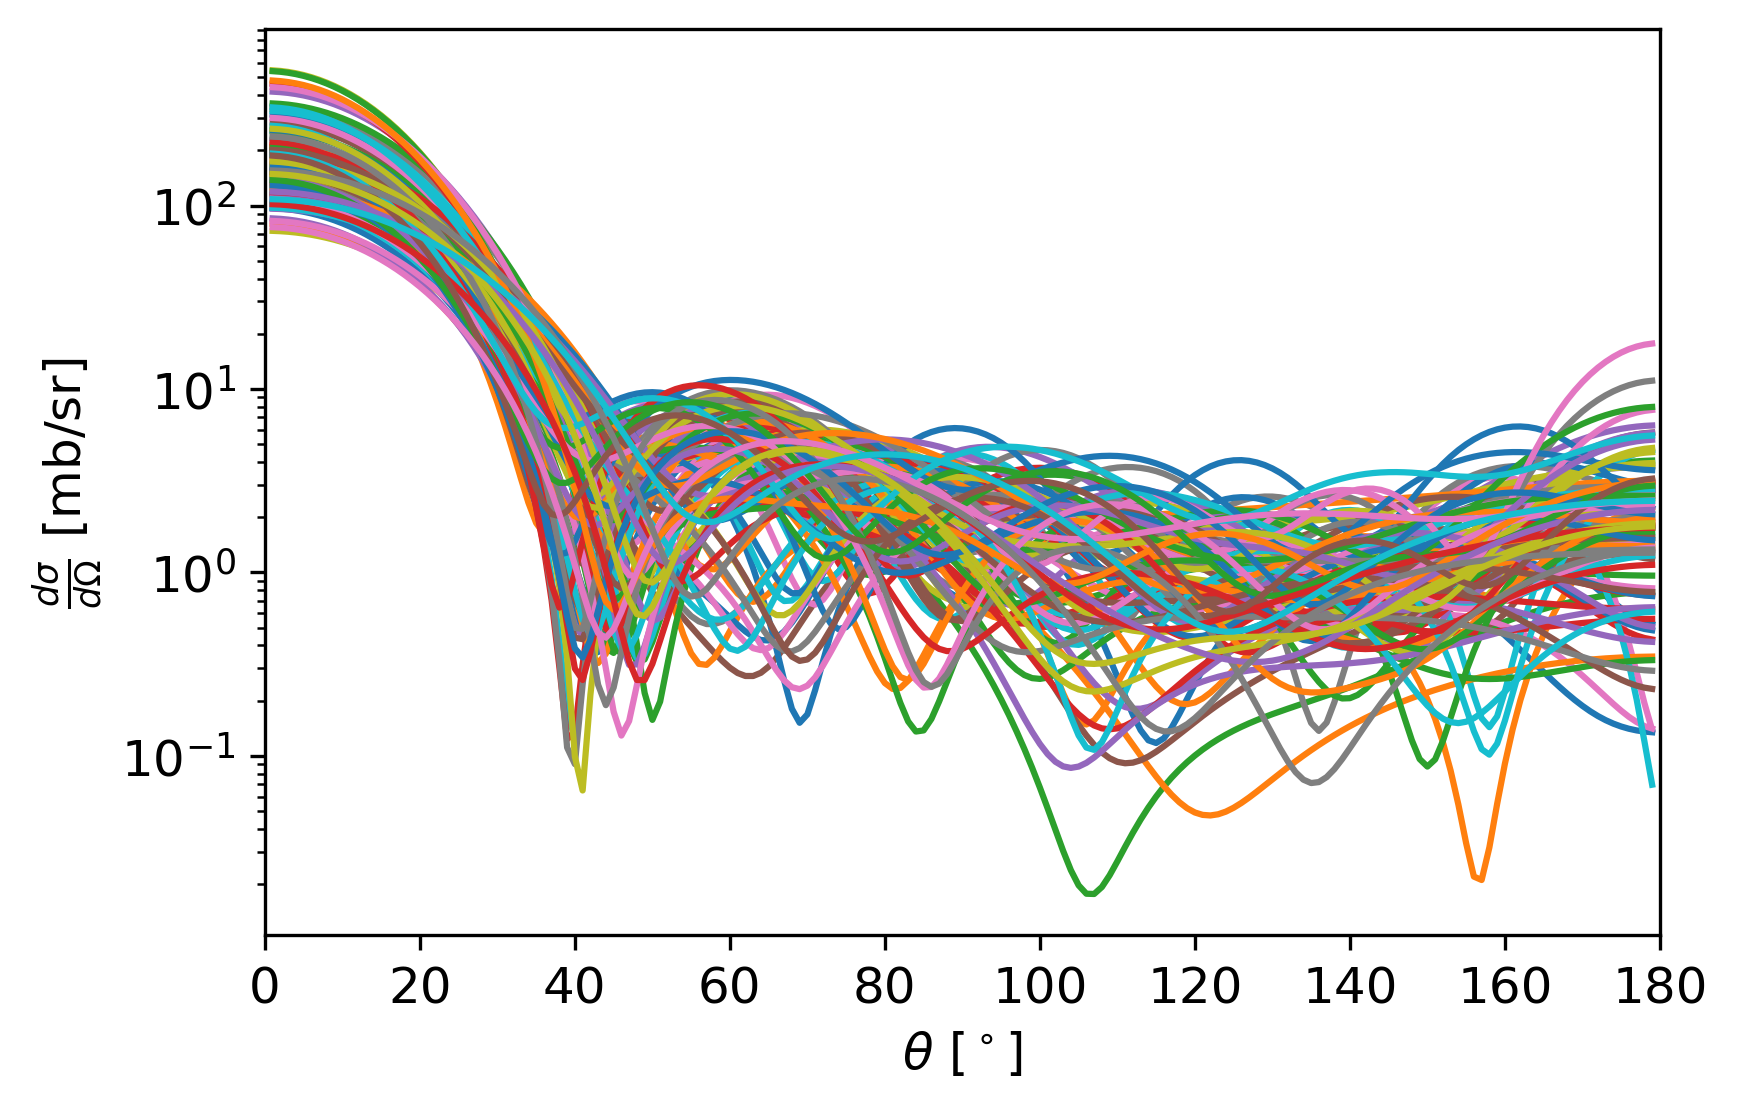

In [13]:
# now let's plot the differential scattering cross section for each of these samples test points!
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
fig.patch.set_facecolor("white")


for i in range(n_test):
    ax.plot(angles, test_CS[i])
ax.set_yscale("log")
plt.xlim([0, 180])
plt.xlabel(r"$\theta$ [$^\circ$]")
plt.ylabel(r"$\frac{d \sigma}{d \Omega}$ [mb/sr]")
plt.show()

In [14]:
prediction_list = []
times_list = []
for i in range(len(test_samples)):
        st = time.time()
        predicted = saeMCMC_fullangles.emulate_dsdo(test_samples[i])
        et = time.time()
        prediction_list.append(predicted)
        times_list.append(et - st)

residual_list_relative = []
residual_list_all = []
residual_list_median = []


#Calculating residuals over all the angles:
for i in range(len(test_samples)):
    residual_list_relative.append(
        np.fabs((prediction_list[i] - test_CS[i])) / (test_CS[i])
    )
    residual_list_median.append(np.median(residual_list_relative[i]))
    residual_list_all.append(prediction_list[i] - test_CS[i])


In [15]:
residual_list_all=np.array(residual_list_all)

In [ ]:

rmse_list=[]
residuals=residual_list_all.T[anglesX]

plots_per_row = 5
num_of_rows = len(residuals) // plots_per_row + (len(residuals) % plots_per_row > 0)

# Set up the figure size, you can adjust it as needed
plt.figure(figsize=(15, num_of_rows * 3))

# Loop over the list of residuals and create a histogram for each
for i, residual in enumerate(residuals):
    # Create a subplot for each histogram
    ax=plt.subplot(num_of_rows, plots_per_row, i + 1)
    
#     # Plot the histogram
#     plt.hist(residual, bins=20, alpha=0.75, edgecolor='black', density=True)
    
    # Plot the histogram and normalize it
    ax.hist(residual, bins=40, alpha=0.75, edgecolor='black', density=True)

    
    
    # Fit a Gaussian distribution to the residuals
    mu=np.mean(residuals[i])
    std = np.std(residuals[i])
    rmse_list.append(np.sqrt(mu**2+std**2))

    
    # Plot the Gaussian distribution
    xmin=np.min(residuals[i])
    xmax = np.max(residuals[i])

    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, 'r', linewidth=2)
    
                     
                     
    ax.axvline(x=0, color='magenta', linestyle='--', linewidth=1.5)
    # Optional: Set a title or labels
    plt.title(f'Angle {anglesX[i]+1}')
    plt.xlabel('Residual')
    plt.ylabel('Density')
    
    # Optional: Set a tight layout so the plots are neatly arranged
    plt.tight_layout()

# Show the plot
plt.show()

## Generating the pseudo data

In [17]:
if flag_provided_data==0:

    #Percentage error to be used in the cs
    sigma_err=0.1

    # Defining the data we are interest in. We defined the "x" values on the begining of the notebook

    f_exact = saeMCMC_fullangles.exact_dsdo(alphaKD)
        
    yperfect =f_exact[anglesX]

    yerr=yperfect*sigma_err
    np.random.seed(142857)

    y_measured=[]

    for i in range(len(yperfect)):
        y_measured.append(yperfect[i]+np.random.normal(0, yperfect[i]*sigma_err))
        
    y_measured=np.array(y_measured)





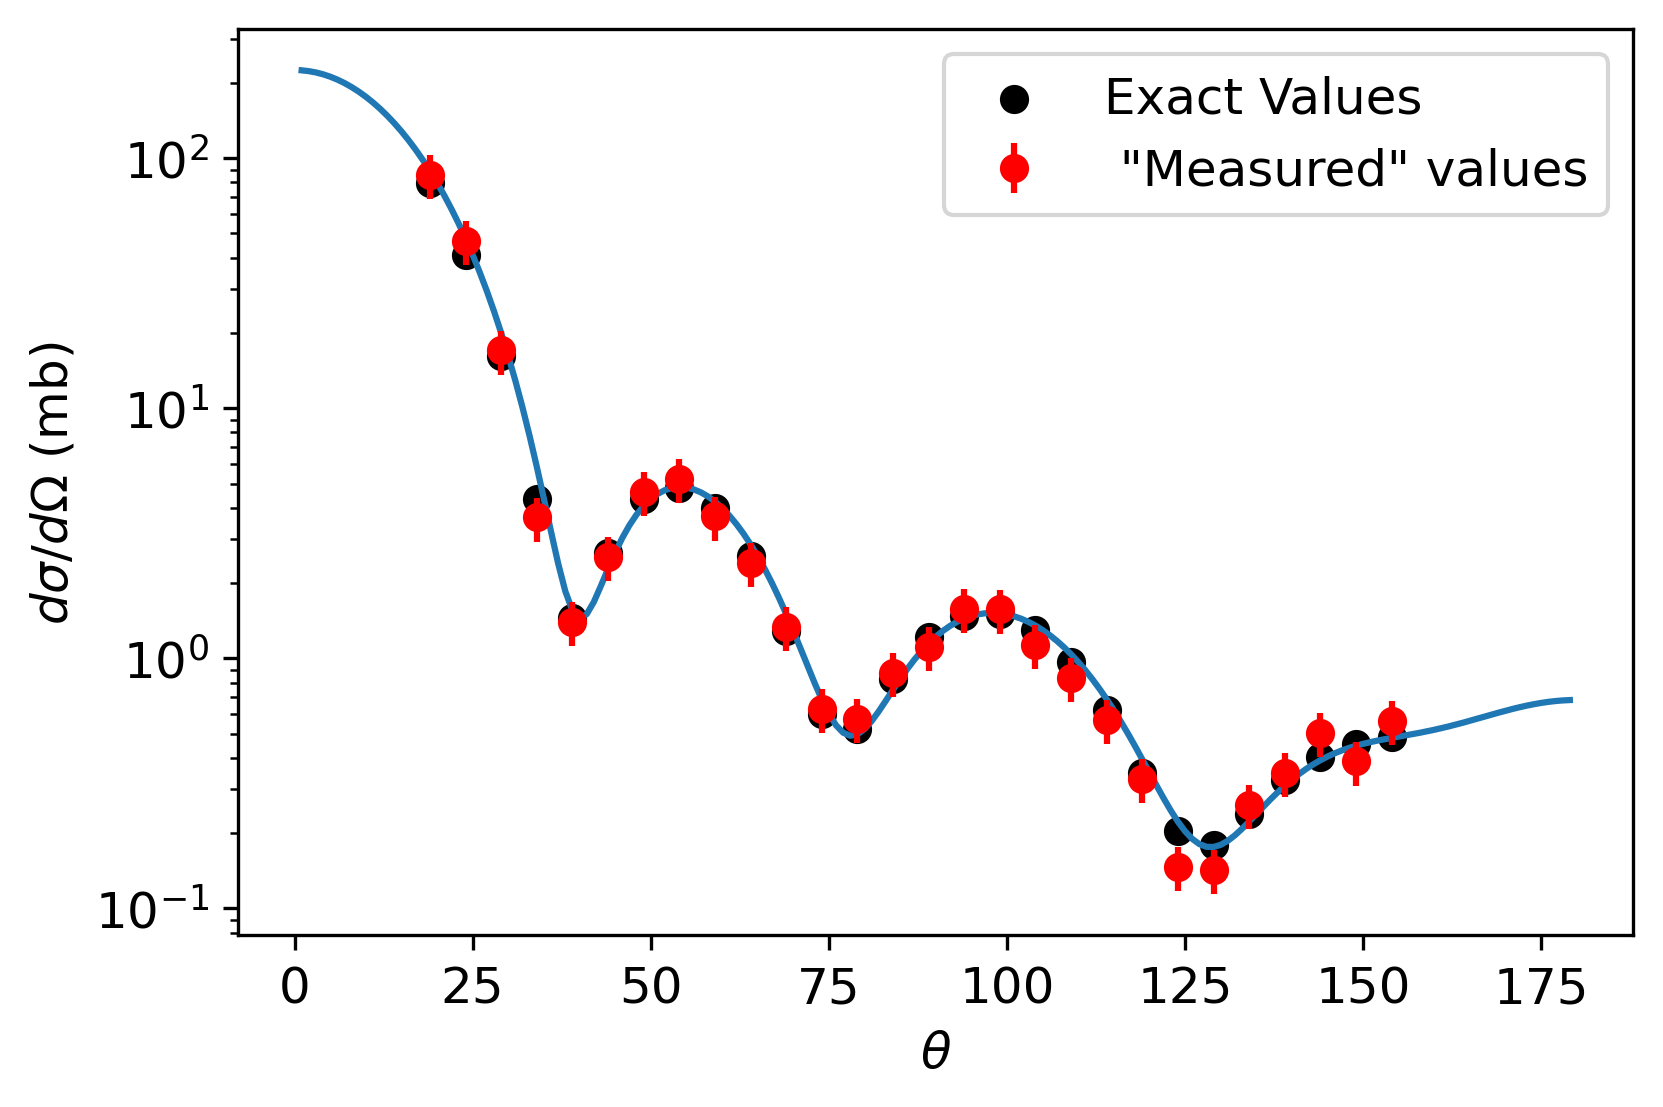

In [22]:
fig, ax = plt.subplots(figsize=(6,4),dpi=300)
fig.patch.set_facecolor('white')

if flag_provided_data==0:
    ax.plot(angles,f_exact)
    ax.scatter(anglesX, yperfect,color='k',label='Exact Values')

ax.errorbar(anglesX, y_measured, yerr=np.array(y_measured)*0.2, fmt="o", c="r",label=' "Measured" values')

ax.legend()

ax.set_yscale('log')
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$d\sigma/d\Omega$ (mb)');

## Specifying the Prior

In [26]:
# In this default we are assuming uncorrelated Gaussian priors. Advanced users can provide covariance matrices for correlations

# Specifying the priors, we believe the answer that explains the data shouldn't be too far away from the KD parameters
alphaCentralPrior = alphaCentral

#We are using Gaussian priors with a standard deviation of 15% of their respective centers
SigmasPrior = [abs(param_val * 0.25) for param_val in alphaCentralPrior]

# We use a smaller scale for the starting values of the MCMC chains so that we minimize the chances of one
# starting in a negative value of the diffuseness or the radii

#This scale is very important: since the optical potential posterior parameter surface is highly multimodal we would like to limit ourself for this tutorial
#to study a vicinity of the main mode closer to our prior. We will start our walkers very close to the prior center.
MCMCScale = [abs(param_val * 0.05) for param_val in alphaCentralPrior]

#This error scale comes from the CAT plot we showed at the begining. The factor of 5 is to be overly conservative and reduce the chance of under-estimation
# Emulator_Error=5*10**(-2)
#Alternatively, we might decide to use the list of errors obtained before to be more precise on each angle
Emulator_error_list=np.copy(rmse_list)

## Going Bayesian with Surmise

We will use surmise, another BAND-developed package for connecting all the tools and softwares (such as our ROSE emulator) for performing Bayesian analysis.

Check out surmise's documentation webpage for more information: https://surmise.readthedocs.io/en/latest/

Our sample rate for the emulator is around 3 miliseconds, which means around 20k samples per minute. We are choosing a relatively small amount of samples and chains to have the calibration done in a couple of minutes. You can of course run it for longer and obtain millions of samples to build very detailed and rich corner plots.

In [29]:
from surmise.emulation import emulator
from surmise.calibration import calibrator

X = np.copy(angles_theta)/180*np.pi
# X = np.copy(anglesX)
y = np.copy(y_measured)
# y = np.copy(yperfect)
# yerr = np.copy(dxs_err) # err in data

# obsvar = 1.0 * np.square(yerr) + np.square(Emulator_error_list)
#At the end we didn't use the emulator's error to be more conservative, adding a 1% error because of it
obsvar = 1.0 * np.square(yerr) + 1.0 * np.square(0.1*yerr)

StepSizes0 = 0.007 * np.abs( alphaCentral )

numsamp = 2000
total_chains = 20
numcores = 8
BurnSamples0 = 500

In [33]:
class prior_scattering:
    """ This defines the class instance of priors provided to the method. """


    def lpdf(theta):
        
        total_prior_pdf=sps.norm.logpdf(theta[:, 0], alphaCentralPrior[0],SigmasPrior[0] )
        
        for i in range(1,len(alphaCentralPrior)):
            total_prior_pdf=total_prior_pdf+ sps.norm.logpdf(theta[:, i], alphaCentralPrior[i],SigmasPrior[i] )
            
            
            
        return (total_prior_pdf).reshape((len(theta), 1))


    def rnd(n):
        totalRandomSamples=[]
        for i in range(len(alphaCentralPrior)):
            totalRandomSamples.append(sps.norm.rvs( alphaCentralPrior[i], MCMCScale[i],   size=n))
        
        totalRandomSamplesNumpy=np.array(totalRandomSamples)
        
        return totalRandomSamplesNumpy.T
        
def calibration_runner(rbm,x,y,obsvar,test_params,numsamp,i,caldir):
   
    cal = calibrator(emu=rbm,
                   y=y,
                   x=x,
                   thetaprior=prior_scattering, 
                   method='directbayes',
                   yvar=obsvar, 
                   args={
                       'theta0': test_params.reshape(1,nparams),
                       'sampler': 'metropolis_hastings',
                       'numsamp' : numsamp,
                       'stepType' : 'normal',
                       'stepParam' : StepSizes0,
                       'burnSamples' : BurnSamples0,
                       'verbose': True
                   })
                       
 
    calfile = os.path.join(caldir,"caltheta_{}.out".format(i))
    np.savetxt(calfile,cal.info['thetarnd'])

    return cal.info['thetarnd']

In [34]:
random.seed(142857)



caldir = os.path.join(
    os.getcwd(), "Cal-" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
)
os.makedirs(caldir, exist_ok=True)

rand_params = prior_scattering.rnd(total_chains)

In [35]:
rbm = emulator(method='nuclear-ROSE', args={'rose_emu': saeMCMC_fullangles, 
#                                             'emu_variance_constant': Emulator_Error, 
                                            'angle_atol': 1e-1
                                           })

In [36]:

st = time.time()
sep_chains = []
chain0 = calibration_runner(rbm, X, y, obsvar, rand_params[0], numsamp, 0, caldir)
sep_chains.append(chain0)
all_chains = chain0

for ij in tqdm(range(total_chains - 1)):
    current_cal = calibration_runner(
        rbm, X, y, obsvar, rand_params[ij], numsamp, ij + 1, caldir
    )

    all_chains = np.vstack(
        (
            all_chains,
            current_cal,
        )
    )
    
    sep_chains.append(current_cal)

    print("Percentage Completed ", int((ij + 1) / (total_chains - 1) * 100))
    
sep_chains = np.array(sep_chains)
et = time.time()
print("Total time:", et - st)

At sample 30000, acceptance rate is 0.2976.
Final Acceptance Rate:  0.33828


  0%|                                                                                            | 0/19 [00:00<?, ?it/s]/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.31153333333333333.
Final Acceptance Rate:  0.33562



  5%|████▎                                                                            | 1/19 [03:21<1:00:27, 201.52s/it]

Percentage Completed  5
At sample 30000, acceptance rate is 0.3087.
Final Acceptance Rate:  0.3385



 11%|████████▋                                                                          | 2/19 [06:29<54:49, 193.49s/it]

Percentage Completed  10
At sample 30000, acceptance rate is 0.2781.
Final Acceptance Rate:  0.31476



 16%|█████████████                                                                      | 3/19 [09:38<51:06, 191.67s/it]

Percentage Completed  15
At sample 30000, acceptance rate is 0.3010333333333333.
Final Acceptance Rate:  0.33504



 21%|█████████████████▍                                                                 | 4/19 [12:49<47:51, 191.41s/it]

Percentage Completed  21


/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.29883333333333334.
Final Acceptance Rate:  0.3297



 26%|█████████████████████▊                                                             | 5/19 [16:07<45:09, 193.52s/it]

Percentage Completed  26
At sample 30000, acceptance rate is 0.31466666666666665.
Final Acceptance Rate:  0.34992



 32%|██████████████████████████▏                                                        | 6/19 [19:22<42:03, 194.11s/it]

Percentage Completed  31


/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.28296666666666664.
Final Acceptance Rate:  0.31756



 37%|██████████████████████████████▌                                                    | 7/19 [22:32<38:34, 192.90s/it]

Percentage Completed  36
At sample 30000, acceptance rate is 0.2997.
Final Acceptance Rate:  0.32626



 42%|██████████████████████████████████▉                                                | 8/19 [26:13<36:58, 201.67s/it]

Percentage Completed  42
At sample 30000, acceptance rate is 0.2836666666666667.
Final Acceptance Rate:  0.31614



 47%|███████████████████████████████████████▎                                           | 9/19 [29:54<34:39, 207.90s/it]

Percentage Completed  47
At sample 30000, acceptance rate is 0.29583333333333334.
Final Acceptance Rate:  0.33248



 53%|███████████████████████████████████████████▏                                      | 10/19 [33:32<31:37, 210.84s/it]

Percentage Completed  52


/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.3091.
Final Acceptance Rate:  0.33828



 58%|███████████████████████████████████████████████▍                                  | 11/19 [37:05<28:12, 211.52s/it]

Percentage Completed  57


/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.3058666666666667.
Final Acceptance Rate:  0.33216



 63%|███████████████████████████████████████████████████▊                              | 12/19 [40:39<24:47, 212.44s/it]

Percentage Completed  63
At sample 30000, acceptance rate is 0.2954.
Final Acceptance Rate:  0.33146



 68%|████████████████████████████████████████████████████████                          | 13/19 [44:13<21:17, 212.84s/it]

Percentage Completed  68


/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.3207.
Final Acceptance Rate:  0.34824



 74%|████████████████████████████████████████████████████████████▍                     | 14/19 [47:47<17:46, 213.24s/it]

Percentage Completed  73
At sample 30000, acceptance rate is 0.31733333333333336.
Final Acceptance Rate:  0.34692



 79%|████████████████████████████████████████████████████████████████▋                 | 15/19 [51:18<14:10, 212.51s/it]

Percentage Completed  78


/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.29133333333333333.
Final Acceptance Rate:  0.33674



 84%|█████████████████████████████████████████████████████████████████████             | 16/19 [54:46<10:33, 211.16s/it]

Percentage Completed  84


/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.31966666666666665.
Final Acceptance Rate:  0.34304



 89%|█████████████████████████████████████████████████████████████████████████▎        | 17/19 [58:17<07:02, 211.05s/it]

Percentage Completed  89


/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.30266666666666664.
Final Acceptance Rate:  0.33432



 95%|███████████████████████████████████████████████████████████████████████████▊    | 18/19 [1:01:47<03:30, 210.82s/it]

Percentage Completed  94


/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.3152333333333333.
Final Acceptance Rate:  0.3332


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [1:05:14<00:00, 206.01s/it]

Percentage Completed  100
Total time: 4110.646800279617


## Plotting the results of the calibration

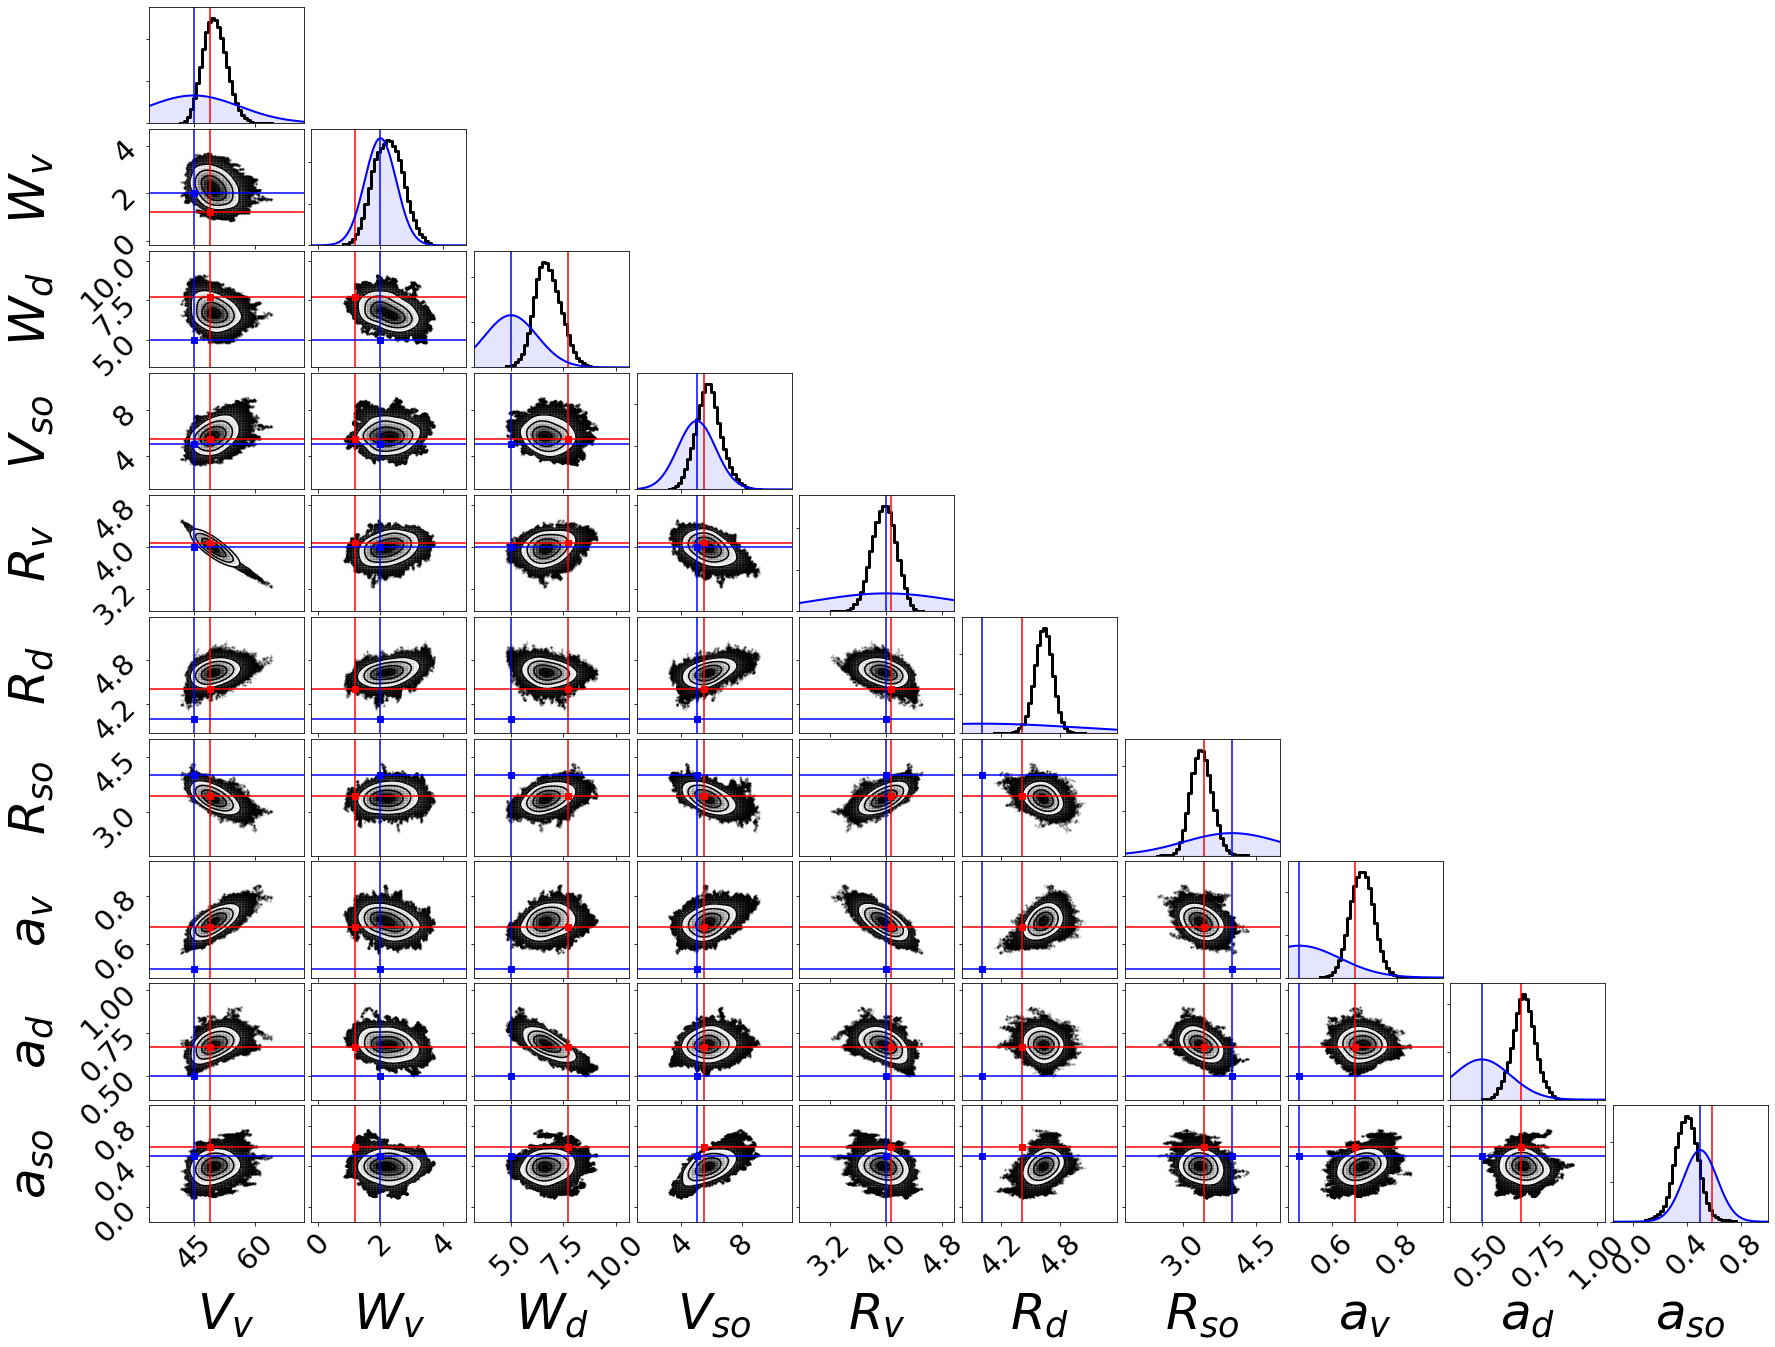

In [40]:
# The plotting routinge to make the gorgeous corner plots! For some reason we have to run it twice to make the label
# size for the ticks to be correct

plt.rc("xtick", labelsize=29)
plt.rc("ytick", labelsize=29)

bins_target=30
ws = [abs(max(all_chains[:,i])-min(all_chains[:,i]))/bins_target for i in range(len(all_chains.T))]

# figure=corner.corner(samples_prior,
#     labels=[
#         "$V_v$",
#         "$W_v$",
#         "$W_d$",
#         "$V_{so}$",
# #         "$W_{so}$",
#         "$R_v$",
#         "$R_d$",
#         "$R_{so}$",
#         "$a_v$",
#         "$a_d$",
#         "$a_{so}$"
#     ],
#     labelpad=0.2,
#     weights=np.full(len(samples_prior),(len(all_chains))/(len(samples_prior))),
#     bins=[int(abs(max(samples_prior[:,i])-min(samples_prior[:,i]))/ws[i]) for i in range(len(samples_prior.T))],
#     color='b',
#     # bins=20,
#     label_kwargs={"fontsize": 50},
#     hist_kwargs={"linewidth": 3},
#     quantiles=None,
#     truths=alphaCentral,
#     truth_color="cyan",
#     smooth=(1.7),
#     smooth1d=1.0
# )


# corner.corner(
#     all_chains,fig=figure,
figure=corner.corner(all_chains,
    labels=[
        "$V_v$",
        "$W_v$",
        "$W_d$",
        "$V_{so}$",
#         "$W_{so}$",
        "$R_v$",
        "$R_d$",
        "$R_{so}$",
        "$a_v$",
        "$a_d$",
        "$a_{so}$"
    ],
    labelpad=0.3,
    # bins=20,
    bins=[int(abs(max(all_chains[:,i])-min(all_chains[:,i]))/ws[i]) for i in range(len(all_chains.T))],
    label_kwargs={"fontsize": 50},
    hist_kwargs={"linewidth": 3},
    quantiles=None,
    truths=alphaKD,
    truth_color="r",
    smooth=(1.7),
    smooth1d=1.0
)


dim=len(all_chains[0]) 
fudge_numbers=[1,1,1,1,1,1,1,1,1,1]
ranges=[
    [min(all_chains[:,i]) - 0.35*fudge_numbers[i]*( max(all_chains[:,i])-min(all_chains[:,i]) ),
     max(all_chains[:,i]) + 0.35*fudge_numbers[i]*(max(all_chains[:,i])-min(all_chains[:,i]))
    ] 
    
    for i in range(len(all_chains.T))]


axes = np.array(figure.axes).reshape((dim, dim))
max_ticks=3
# print()
for i in range(dim):
    ax = axes[i, i]
    ax.xaxis.set_major_locator(MaxNLocator(max_ticks))
    ax.yaxis.set_major_locator(MaxNLocator(max_ticks))
    ax.set_xlim(ranges[i][0],ranges[i][1])
    ax.axvline(alphaCentral[i], color="blue")
   

    x_grid=np.linspace(ranges[i][0],ranges[i][1],200)
    ax.plot(x_grid,len(all_chains)*ws[i]*norm.pdf(x_grid, alphaCentral[i], SigmasPrior[i]),color='b',linewidth=2)
    ax.fill_between(x_grid, len(all_chains)*ws[i]*norm.pdf(x_grid, alphaCentral[i], SigmasPrior[i]), color='blue', alpha=0.1)
    ax.xaxis.set_major_locator(MaxNLocator(max_ticks))
    ax.yaxis.set_major_locator(MaxNLocator(max_ticks))



    for j in range(i):
        ax.xaxis.set_major_locator(MaxNLocator(max_ticks))
        ax.yaxis.set_major_locator(MaxNLocator(max_ticks))
        ax = axes[i, j]
        ax.set_ylim(ranges[i][0],ranges[i][1])
        ax.set_xlim(ranges[j][0],ranges[j][1])
        
        
#         ax.axvline(alphaCentral[i], color="blue")
#         ax.axhline(alphaCentral[j], color="blue")
#         ax.plot(alphaCentral[i], alphaCentral[j], "sb")
        
        
        ax.axvline(alphaCentral[j], color="blue")
        ax.axhline(alphaCentral[i], color="blue")
        
        ax.plot(alphaCentral[j], alphaCentral[i], "sb")
        
        
        ax.xaxis.set_major_locator(MaxNLocator(max_ticks))
        ax.yaxis.set_major_locator(MaxNLocator(max_ticks))
        




width = 24
height = 18
figure.set_size_inches(width, height)

plt.show()


In [41]:
rng = np.random.default_rng()
test_samples_posterior= rng.choice(all_chains, (100), replace=False)

In [42]:
# calculate the exact differential cross section for the 100 test parameters from the posterior
test_CS_posterior = []
for params in tqdm(test_samples_posterior):
    test_CS_posterior.append(saeMCMC_fullangles.exact_dsdo(params))

  0%|                                                                                           | 0/100 [00:00<?, ?it/s]/home/pablo/.local/lib/python3.10/site-packages/rose/free_solutions.py:52: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda z: H_minus(z, ell, eta), rho, dx=dx)
/home/pablo/.local/lib/python3.10/site-packages/rose/free_solutions.py:45: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda z: H_plus(z, ell, eta), rho, dx=dx)
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [04:53<00:00,  2.94

In [43]:
prediction_list_posterior = []
times_list_posterior = []
for i in range(len(test_samples_posterior)):
        st = time.time()
        predicted = saeMCMC_fullangles.emulate_dsdo(test_samples_posterior[i])
        et = time.time()
        prediction_list_posterior.append(predicted)
        times_list_posterior.append(et - st)

residual_list_relative_posterior = []
residual_list_all_posterior = []
residual_list_median_posterior = []


#Calculating residuals over all the angles:
for i in range(len(test_samples_posterior)):
    residual_list_relative_posterior.append(
        np.fabs((prediction_list_posterior[i] - test_CS_posterior[i])) / (test_CS_posterior[i])
    )
    residual_list_median_posterior.append(np.median(residual_list_relative_posterior[i]))
    residual_list_all_posterior.append(prediction_list_posterior[i] - test_CS_posterior[i])


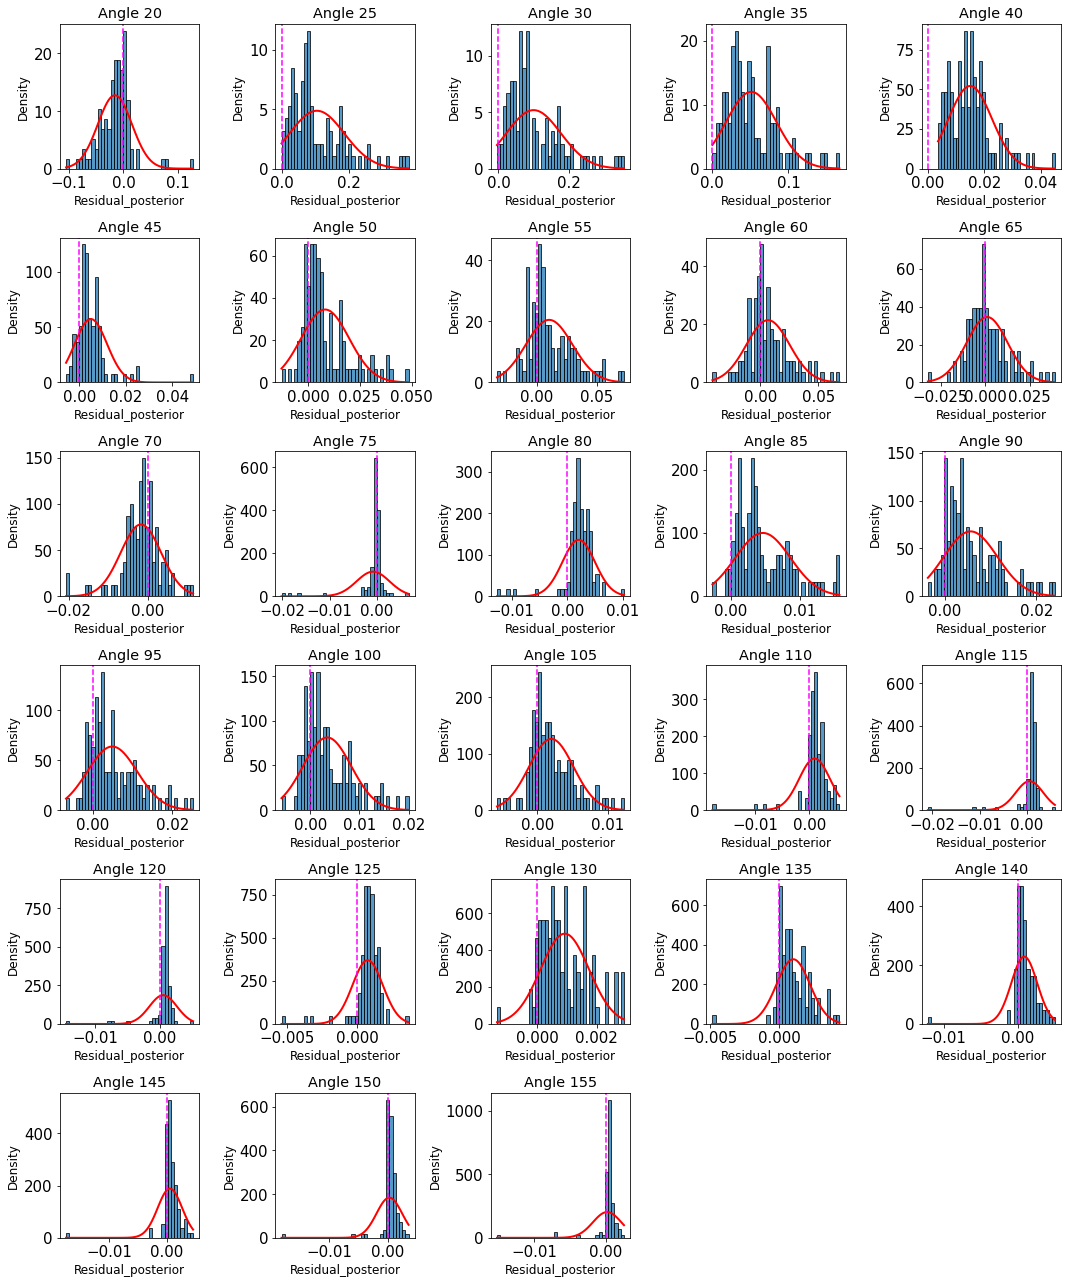

In [44]:

rmse_list_posterior=[]
residuals_posterior=np.array(residual_list_all_posterior).T[anglesX]



plots_per_row = 5
num_of_rows = len(residuals_posterior) // plots_per_row + (len(residuals_posterior) % plots_per_row > 0)

plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)

# Set up the figure size, you can adjust it as needed
plt.figure(figsize=(15, num_of_rows * 3))



# Loop over the list of residuals and create a histogram for each
for i, residual in enumerate(residuals_posterior):
    # Create a subplot for each histogram
    ax=plt.subplot(num_of_rows, plots_per_row, i + 1)
    
#     # Plot the histogram
#     plt.hist(residual, bins=20, alpha=0.75, edgecolor='black', density=True)
    
    # Plot the histogram and normalize it
    ax.hist(residual, bins=40, alpha=0.75, edgecolor='black', density=True)

    
    
    # Fit a Gaussian distribution to the residuals
    mu=np.mean(residuals_posterior[i])
    std = np.std(residuals_posterior[i])
    rmse_list_posterior.append(np.sqrt(mu**2+std**2))

    
    # Plot the Gaussian distribution
    xmin=np.min(residuals_posterior[i])
    xmax = np.max(residuals_posterior[i])

    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, 'r', linewidth=2)
    
                     
                     
    ax.axvline(x=0, color='magenta', linestyle='--', linewidth=1.5)
    # Optional: Set a title or labels
    plt.title(f'Angle {anglesX[i]+1}')
    plt.xlabel('Residual_posterior')
    plt.ylabel('Density')
    # Optional: Set a tight layout so the plots are neatly arranged
    plt.tight_layout()

# Show the plot
plt.show()

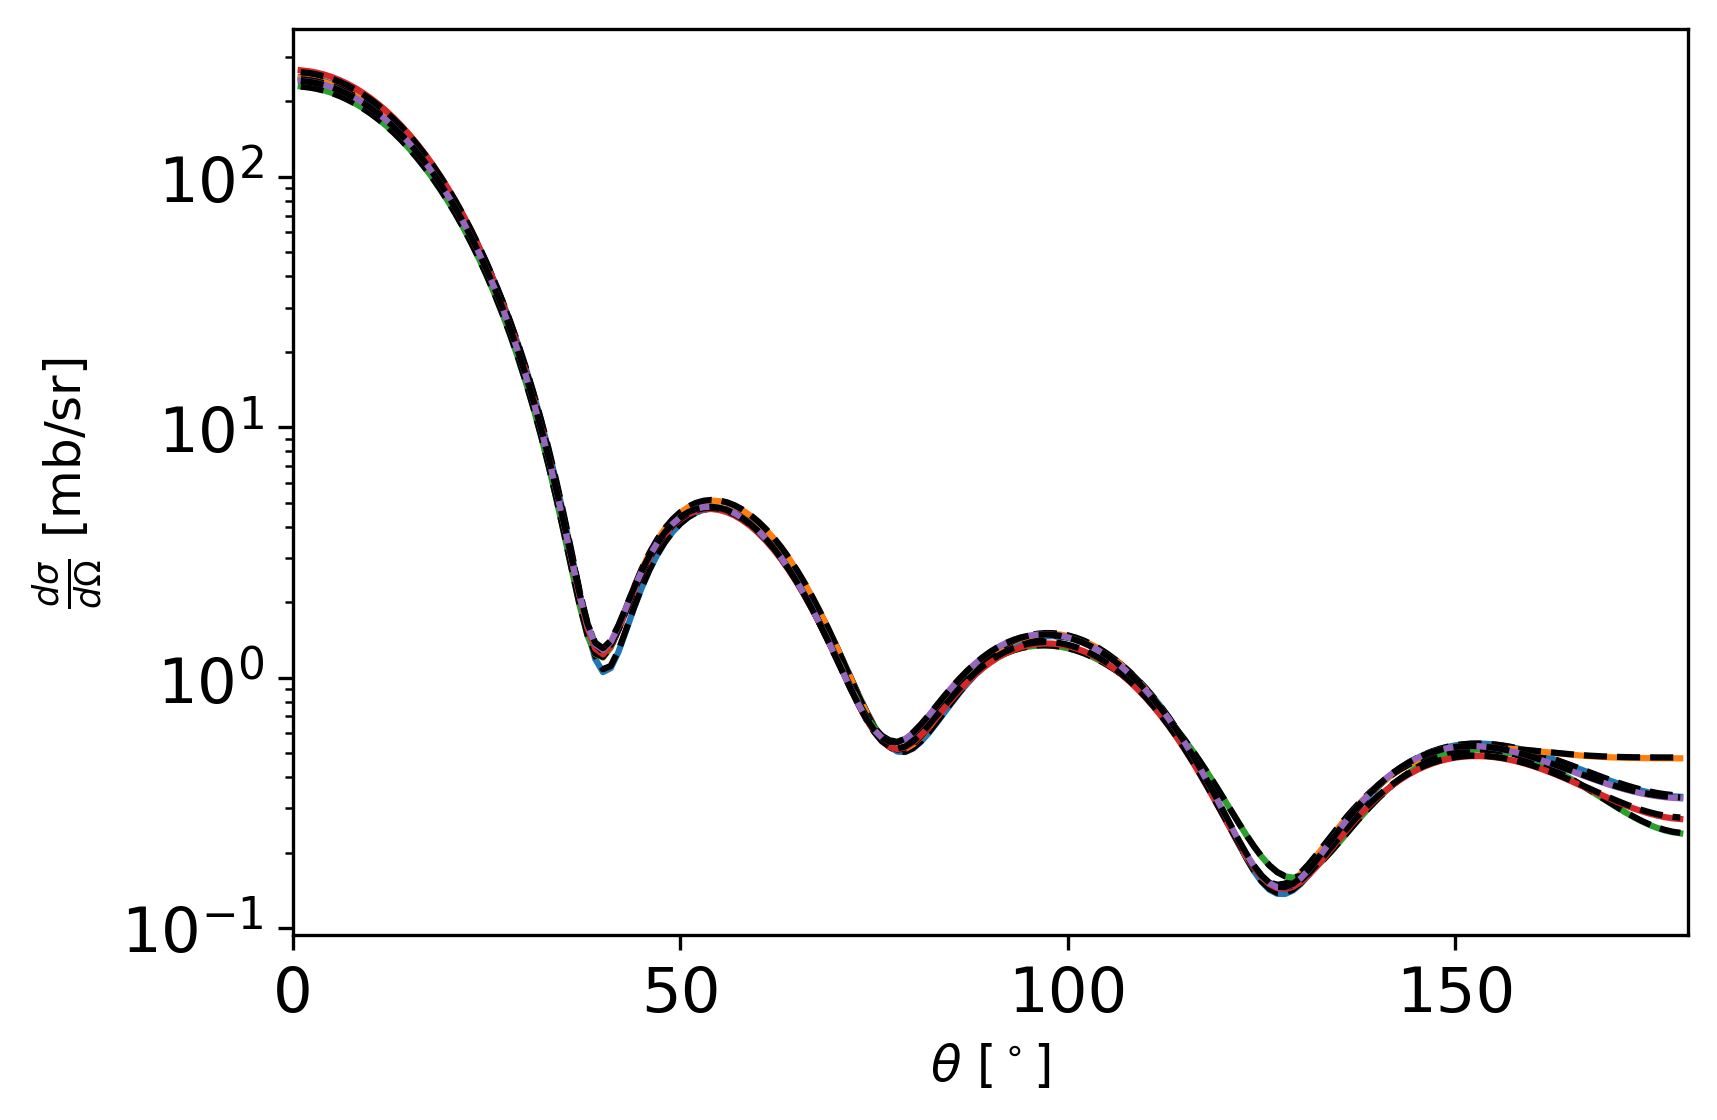

In [45]:
# now let's plot the differential scattering cross section for each of these samples test points!
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
fig.patch.set_facecolor("white")


for i in range(80,85):
    ax.plot(angles, test_CS_posterior[i])
    ax.plot(angles, prediction_list_posterior[i],color="k", linestyle="--")
ax.set_yscale("log")
plt.xlim([0, 180])
plt.xlabel(r"$\theta$ [$^\circ$]")
plt.ylabel(r"$\frac{d \sigma}{d \Omega}$ [mb/sr]")
plt.show()

Very interesting! In red we can see the original parametrization by Koning-Delaroche that we used as the center of our prior, the blue lines are the actual prior, and the black ones the posterior. Most parameters are more or less around that value, while some shifted appreciably.Some parameters are very well constrained by the data, while others seem to just be constrained by the prior. 

Thanks to ROSE, we now can make these kinds of analysis VERY fast!

In [95]:
labelsChains = [
    "$V_v$",
    "$W_v$",
    "$W_d$",
    "$V_{so}$",
    "$W_{so}$",
    "$R_v$",
    "$R_d$",
    "$R_{so}$",
    "$a_v$",
    "$a_d$",
    "$a_{so}$",
]

Below we plot the parameters that all the chains, concatenated together, explored. The horizontal red lines are the KD values

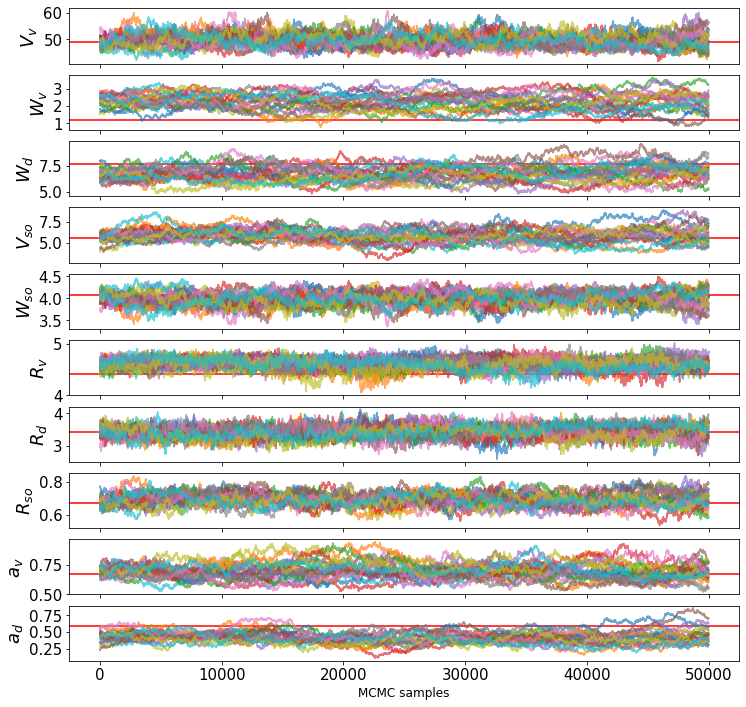

In [96]:
XAll = np.arange(len(anglesX))

plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)
fig, axs = plt.subplots(nparams, 1, figsize=(12, 12), sharex='all')

for i in range(nparams):
    axs[i].axhline(y=alphaKD[i],color='r')
    axs[i].plot(sep_chains[:, :, i].T, alpha=0.65)
    axs[i].set_ylabel(labelsChains[i], fontsize=18)

plt.xlabel('MCMC samples')
plt.show()

## Plotting our final calibrated model alongside the data

In [50]:
#Estimating the emulator error across all angles plotted
rmse_list_full=[]
residuals_full=residual_list_all.T

for i, residual in enumerate(residuals_full):

    mu=np.mean(residuals_full[i])
    std = np.std(residuals_full[i])
    rmse_list_full.append(np.sqrt(mu**2+std**2))

    

In [98]:
rmse_list_full=np.copy(rmse_list_full)

In [99]:
XAll = np.arange(len(anglesX))

In [52]:
# %#%time
rng = np.random.default_rng()
theta_rand = rng.choice(all_chains, (50000), replace=False)

In [53]:
%%time
rndm_m = []

for i in range(len(theta_rand)):
    yvals_rand=saeMCMC_fullangles.emulate_dsdo(theta_rand[i])
    rndm_m.append(yvals_rand +
                   np.random.multivariate_normal(np.full(
                       len(angles)
                       ,0), np.diag(
                       1.0 * np.square(yvals_rand*0.1) + np.square(yvals_rand*0.01)
                   )))   

CPU times: user 1h 11min 35s, sys: 2h 17min 45s, total: 3h 29min 21s
Wall time: 10min 28s


In [54]:
if flag_provided_data==0:
    KD_cs=saeMCMC_fullangles.exact_dsdo(alphaKD)


/home/pablo/.local/lib/python3.10/site-packages/rose/free_solutions.py:52: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda z: H_minus(z, ell, eta), rho, dx=dx)
/home/pablo/.local/lib/python3.10/site-packages/rose/free_solutions.py:45: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda z: H_plus(z, ell, eta), rho, dx=dx)


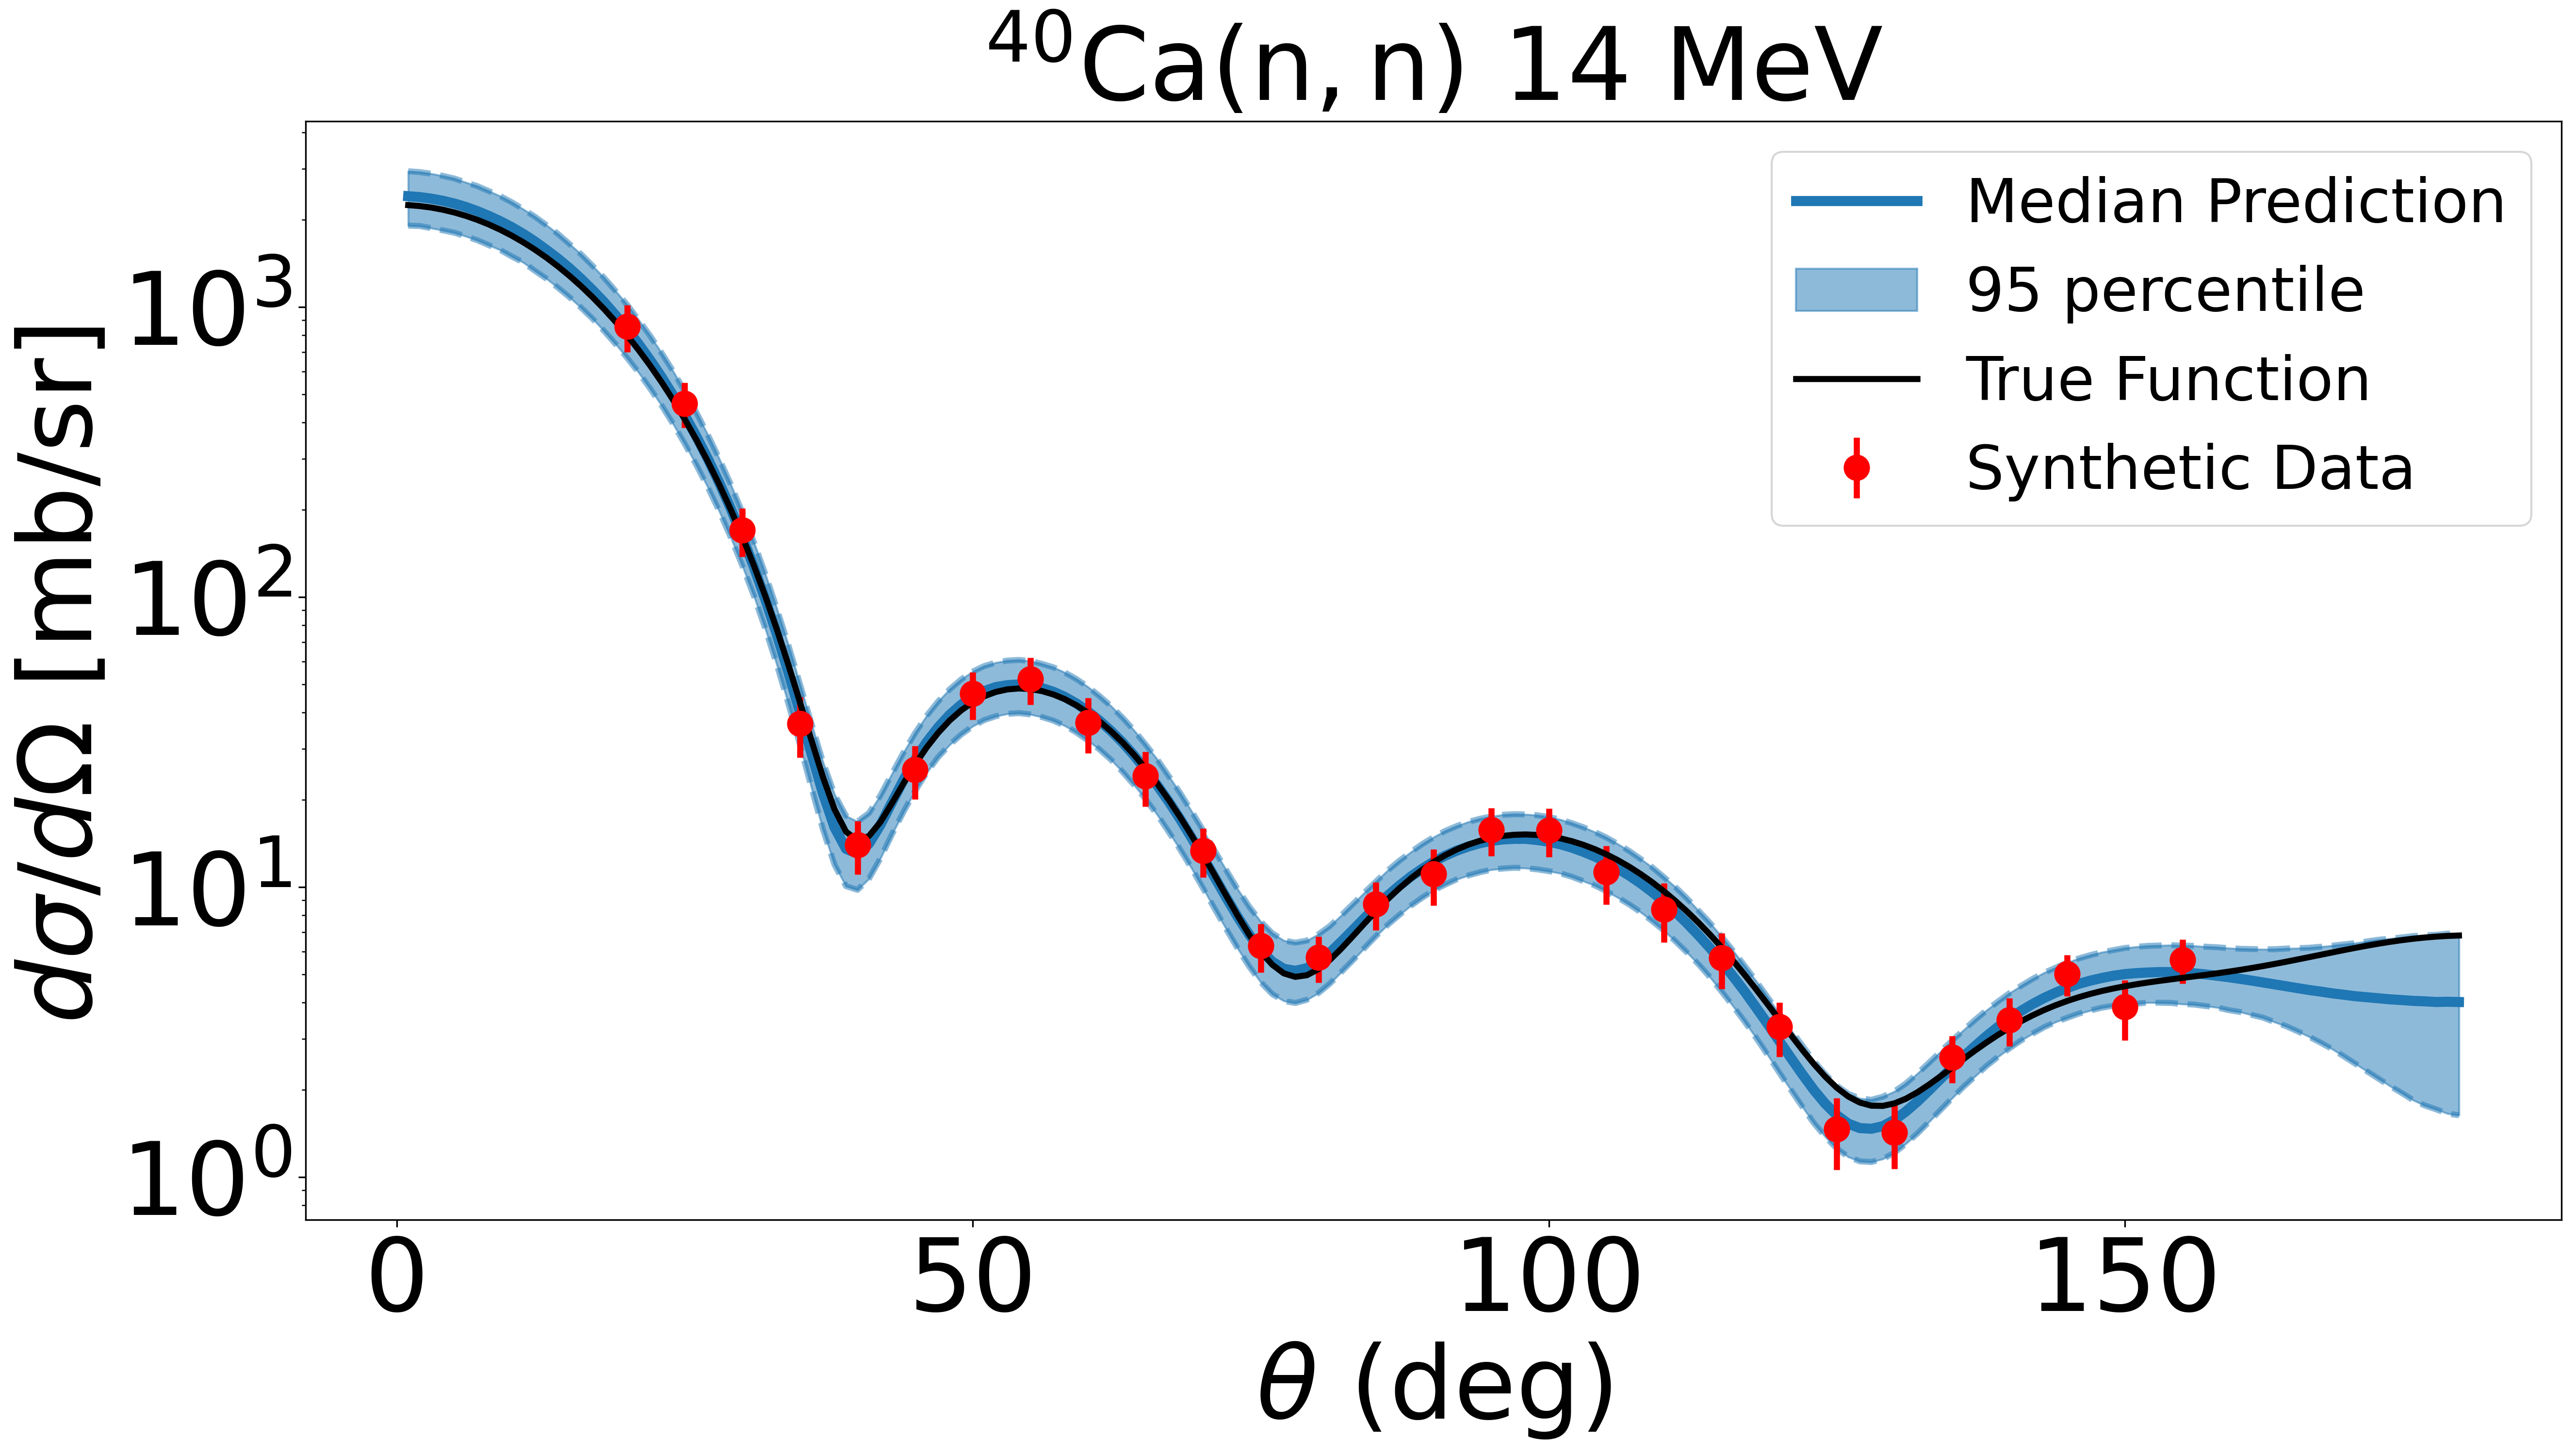

In [56]:

plt.rc("xtick", labelsize=50)  # fontsize of the tick labels
plt.rc("ytick", labelsize=50)

fig, axs = plt.subplots(1, 1, figsize=(20, 10),dpi=300)
median = np.percentile(rndm_m, 50, axis=0)
upper = np.abs(np.percentile(rndm_m, 97.5, axis=0))



lower = np.abs(np.percentile(rndm_m, 2.5, axis=0))

axs.plot(angles, 10*median, color="C0", label='Median Prediction',linewidth=5)

axs.plot(angles, 10*lower, color="C0",linestyle="dashed",linewidth=3,alpha=0.5)
axs.plot(angles, 10*upper, color="C0",linestyle="dashed",linewidth=3,alpha=0.5)

axs.fill_between(angles, 10*lower, 10*upper, color="C0",alpha=0.5, label='95 percentile')

# axs.scatter(angles_theta, 10*y, s=150, c="r", label='Mock Data')
axs.errorbar(angles_theta, 10*y, yerr=10*2 * yerr,linewidth=3,markersize=12, fmt="o", c="r",label='Synthetic Data')

axs.set_yscale("log")

axs.set_xlabel(r"$\theta$ (deg)", fontsize=50)
axs.set_ylabel(r"$d\sigma/d\Omega$ [mb/sr] ", fontsize=50)

if flag_provided_data==0:
    axs.plot(angles, 10*KD_cs, c="k",linewidth=3,label='True Function')


plt.title(r"$^{40}\rm{Ca}(n,n) \ 14\  MeV$", fontsize=50)



plt.legend(fontsize='30')
plt.show()